In [2]:
import sys
import numpy as np
import scipy.io as sp
import pandas as pd
import matplotlib.pyplot as mpl
import datetime as dt
import statsmodels.api as sm
import statsmodels.tsa.api as smtsa
import statsmodels.formula.api as smf
import fredapi
# import dill

In [3]:
sys.path.append('../../../library/metrics/metrics/')
import metrics
import importlib

importlib.reload(metrics)

<module 'metrics' from '../../../library/metrics/metrics/metrics.py'>

In [4]:
%matplotlib inline

In [10]:
(t[0]-366)[0]

715145

In [22]:
FRED_MD_2015SM = sp.loadmat('./data/in/FRED-MD_2015SM.mat')
d = FRED_MD_2015SM.get('data')
v = FRED_MD_2015SM.get('dataName')
v = [v[0][i][0] for i in range(v.shape[1])]
t = FRED_MD_2015SM.get('dates')
t = [dt.date.fromordinal((t[i]-366)[0]) for i in range(t.shape[0])]
df_vars = pd.DataFrame(d,index=t,columns=v)

In [24]:
instruments = sp.loadmat('./data/in/instruments.mat')
IV = instruments.get('IV')
d = IV[0][0][0]
v = IV[0][0][2]
v = [v[0][i][0] for i in range(v.shape[1])]
t = IV[0][0][1]
t = [dt.date.fromordinal((t[i]-366)[0]) for i in range(t.shape[0])]
df_ins = pd.DataFrame(d,index=t,columns=v)
df_ins.to_csv('./data/out/instruments.csv')

In [25]:
df = df_vars[['INDPRO','UNRATE','CPIAUCSL','CRBPI','FEDFUNDS','GS1']].join(df_ins,how='outer')
df.index = pd.to_datetime(df.index)

In [26]:
df['ln_IP']      = 100*df['INDPRO'].apply(lambda x: np.log(x))
df['ln_CPI']     = 100*df['CPIAUCSL'].apply(lambda x: np.log(x))
df['ln_CRBPI']   = 100*df['CRBPI'].apply(lambda x: np.log(x))
df['d_ln_IP']    = 100*df['INDPRO'].apply(lambda x: np.log(x)).diff()
df['d_ln_CPI']   = 100*df['CPIAUCSL'].apply(lambda x: np.log(x)).diff()
df['d_ln_CRBPI'] = 100*df['CRBPI'].apply(lambda x: np.log(x)).diff()

In [27]:
df['d_IP']    = 100*df['INDPRO'].apply(lambda x: np.log(x)).diff()
df['d_UR']    = 100*df['UNRATE'].diff()
df['d_CPI']   = 100*df['CPIAUCSL'].apply(lambda x: np.log(x)).diff()
df['d_CRBPI'] = 100*df['CRBPI'].apply(lambda x: np.log(x)).diff()
df['d_FFR']   = 1  *df['FEDFUNDS'].diff()
df['d_GS1']   = 1  *df['GS1'].diff()

In [545]:
#df[['d_ln_IP','d_ln_CPI']]  = df[['INDPRO','CPIAUCSL']].apply(lambda x: np.log(x)).diff()

fig, axes = mpl.subplots(3,1,figsize=(10,8))
axes[0].plot(df.d_IP)
axes[1].plot(df.d_CPI)
axes[2].plot(df.d_INT)

In [28]:
var_names_1 = ['ln_IP','UNRATE','ln_CPI','ln_CRBPI','FEDFUNDS']
var_names_2 = ['ln_IP','UNRATE','ln_CPI','ln_CRBPI','GS1']
var_descs_1 = ['Industrial production','Unemployment','Price level','Commodity Price Index','Fed funds rate']
var_descs_2 = ['Industrial production','Unemployment','Price level','Commodity Price Index','1-year yield']
sample = ('1970-01-01','2014-12-01')
nL = 12
nH = 48
ci = 'wbs'
# ci = None
nR = 1000

importlib.reload(metrics)

In [30]:
Mdl1 = metrics.varm(df,nL=nL,var_names=var_names_1,sample=sample)
Mdl1.irf(method='ch',nH=nH,ci=None,nR=nR)

In [31]:
Mdl2 = metrics.varm(df,nL=nL,var_names=var_names_2,sample=sample)
Mdl2.irf(method='iv',idv=4,ins_names=['FF4GK'],nH=nH,ci=None,nR=nR)

In [45]:
Mdl3 = metrics.varm(df,nL=nL,var_names=var_names_2,sample=sample)
Mdl3.irf(method='iv',idv=4,ins_names=['FF4MA'],nH=nH,cl=[0.68,0.90],ci=ci,nR=nR)

 Bootstrap 1000/1000


Mdl = varm(y,nL)
Mdl.irf(method='ch')
Mdl.irf(method='iv',idv=4,instrument=df.loc['1969-01-01':'2014-12-01',['FF4GK']].values)

Mdl.set_sample(('1969-01-01','2014-12-01'))
Mdl.set_horizon(48)
Mdl.set_lag_length(12)

In [33]:
import matplotlib;
colors = [matplotlib.colors.to_rgb(c) for c in matplotlib.pyplot.rcParams['axes.prop_cycle'].by_key()['color']]
mpl.rcParams.update({'font.size': 10})
# colors

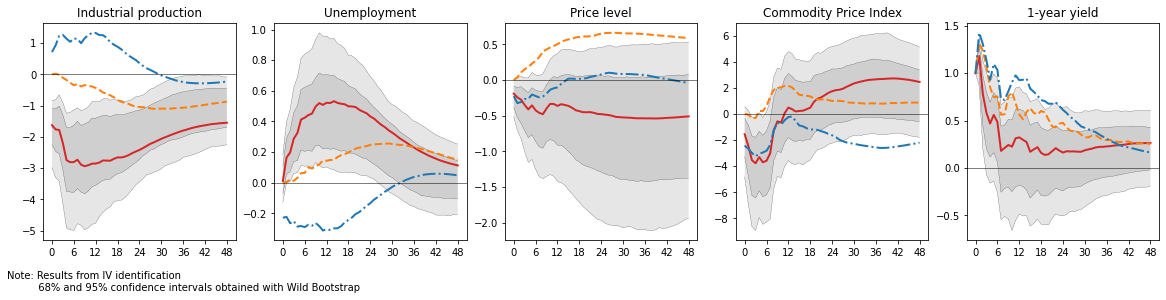

In [47]:
for ids in [4]:
    fig, axes = mpl.subplots(1,5,figsize=(20,4))
    for idp,idr in enumerate([0,1,2,3,4]):
        axes[idp].plot(Mdl3.irfs.iv.ir.mean[:,idr,ids],color=colors[3],lw=2);
        axes[idp].plot(Mdl3.irfs.iv.ir.q050[:,idr,ids],color=[0.05,0.05,0.05],lw=0.2,ls='-');
        axes[idp].plot(Mdl3.irfs.iv.ir.q950[:,idr,ids],color=[0.05,0.05,0.05],lw=0.2,ls='-');
        axes[idp].plot(Mdl3.irfs.iv.ir.q160[:,idr,ids],color=[0.05,0.05,0.05],lw=0.2,ls='-');
        axes[idp].plot(Mdl3.irfs.iv.ir.q840[:,idr,ids],color=[0.05,0.05,0.05],lw=0.2,ls='-');
        axes[idp].fill_between(range(nH+1),Mdl3.irfs.iv.ir.q050[:,idr,ids],Mdl3.irfs.iv.ir.q950[:,idr,ids],facecolor=[0.05,0.05,0.05], alpha=0.10)
        axes[idp].fill_between(range(nH+1),Mdl3.irfs.iv.ir.q160[:,idr,ids],Mdl3.irfs.iv.ir.q840[:,idr,ids],facecolor=[0.05,0.05,0.05], alpha=0.10)
        axes[idp].plot(Mdl1.irfs.ch.ir.mean[:,idr,ids],color=colors[1],lw=2,ls='--');
        axes[idp].plot(Mdl2.irfs.iv.ir.mean[:,idr,ids],color=colors[0],lw=2,ls='-.');
        axes[idp].axhline(0,color='k',lw=0.5);
        axes[idp].set_xticks(range(0,nH+1,6))
#         axes[idp].legend()
        axes[idp].set_title(var_descs_2[idr]);
#     fig.suptitle('Shock to Fed funds rate vs '+var_descs_1[ids],y=1.02)
    fig.text(0.1,-0.05,'Note: Results from IV identification\n          68% and 95% confidence intervals obtained with Wild Bootstrap');
#     fig.savefig('./figures/png/Mdl1_'+str(ids)+'.png',bbox_inches='tight')
#     fig.savefig('./figures/pdf/Mdl1_'+str(ids)+'.pdf',bbox_inches='tight')